# SFINCS Energy Balance? 
July 16, 2025

I want to validate Manning's equation for describing head loss in open channel flow, using SFINCS

## SFINCS Model Output
I will start by accessing a SFINCS model output.

In [215]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils

yaml_path = '/home/cassandra/Snohomish/test_data/snoho_test.yml'
sf = SfincsModel(data_libs=[yaml_path], root="/home/cassandra/Snohomish/test_build", mode="r")
sf.read_results()

u = sf.results['u'].values
v = sf.results['v'].values
z_surface = sf.results['zs'].values
z_bottom  = sf.results['zb'].values
h = z_surface - z_bottom
x = sf.results['zs'].x.values
y = sf.results['zs'].y.values
t = sf.results['zs'].time.values
n = sf.grid['manning'].values

Grid type not known, trying to read from config file. 
manningfile not found at /home/cassandra/Snohomish/test_build/sfincs.manning
Replacing result: inp
Replacing result: msk
Replacing result: zb
Replacing result: zs
Replacing result: u
Replacing result: v
Replacing result: zsmax
Replacing result: total_runtime
Replacing result: average_dt
Replacing result: status


I'll now plot an overview of an area of the domain I will focus on for this test:

In [216]:
# Define an outer area for plotting
x0 = 567000
x1 = 569000
y0 = 5301000
y1 = 5307000

# Define a focus area for calculations
y_upper = y0 + 4200
y_lower = y0 + 3200
x_left  = x0 + 700
x_right = x0 + 1250
xok2 = np.logical_and(x > x_left, x < x_right)
yok2 = np.logical_and(y > y_lower, y < y_upper)

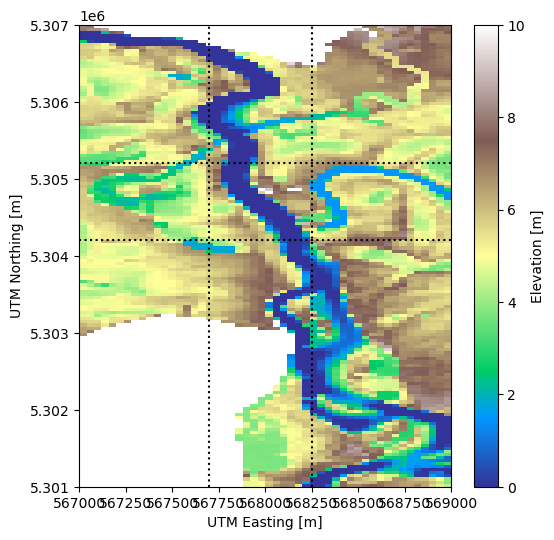

In [217]:
# Plot the overview area
plt.figure(figsize=(6,6))
mesh = plt.pcolormesh(x, y, z_bottom, shading='nearest', cmap='terrain', vmax=10, vmin=0)
cb = plt.colorbar(mesh)
cb.ax.set_ylabel("Elevation [m]")
plt.xlim(x0,x1)
plt.ylim(y0,y1)
plt.xlabel("UTM Easting [m]")
plt.ylabel("UTM Northing [m]")

# Draw a box around the focus area for calculations
plt.axhline(y_lower, color='black', linestyle=':')
plt.axhline(y_upper, color='black', linestyle=':')
plt.axvline(x_left, color='black', linestyle=':')
plt.axvline(x_right, color='black', linestyle=':')

plt.show()

This is an area where the river runs relatively northwards. I'll zoom in on a relatively straight part:

In [218]:
# pick one hour in the middle of data...
tok = np.logical_and(t > t[50], t < t[60])

In [219]:
# Clip data to focus area
x = x[xok2] - x_left
y = y[yok2] - y_lower
n = n[yok2][:,xok2]
zb = z_bottom[yok2][:,xok2]

v = v[tok][:,yok2][:,:,xok2]
u = u[tok][:,yok2][:,:,xok2]
h = h[tok][:,yok2][:,:,xok2]
zs = z_surface[tok][:,yok2][:,:,xok2]

In [220]:
# Compute time averages over this hour
h_avg = np.nanmedian(h, axis=0)
v_avg = np.nanmedian(v, axis=0)
u_avg = np.nanmedian(u, axis=0)
zs_avg = np.nanmedian(zs,axis=0)

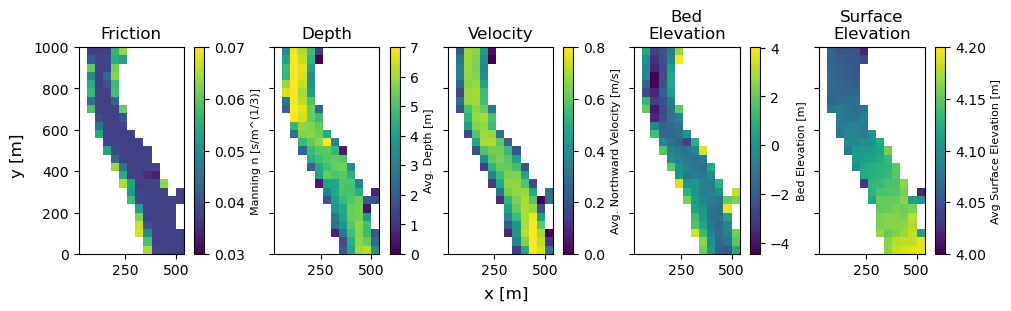

In [221]:
# Plot variables in the focus area. 
fig, axs = plt.subplots(nrows = 1, ncols = 5, constrained_layout=True, figsize=(10,3), sharex=True, sharey=True)

axs[0].set_title("Friction")
n_plot = np.copy(n)
n_plot[np.isnan(h_avg)] = np.nan # Only plot where wetted
m = axs[0].pcolormesh(x,y,n_plot, shading='nearest', vmin=0.03, vmax=0.07)
plt.colorbar(m, ax=axs[0]).ax.set_ylabel("Manning n [s/m^(1/3)]", fontsize=8)

axs[1].set_title("Depth")
m = axs[1].pcolormesh(x,y,h_avg, shading='nearest', vmin=0, vmax=7)
plt.colorbar(m, ax=axs[1]).ax.set_ylabel("Avg. Depth [m]", fontsize=8)

axs[2].set_title("Velocity")
v_plot = np.copy(v_avg)
v_plot[np.isnan(h_avg)] = np.nan  # Only plot where wetted
m = axs[2].pcolormesh(x,y,v_plot, shading='nearest', vmin=0, vmax=0.8)
plt.colorbar(m, ax=axs[2]).ax.set_ylabel("Avg. Northward Velocity [m/s]", fontsize=8)

axs[3].set_title("Bed\nElevation")
zb_plot = np.copy(zb)
zb_plot[np.isnan(h_avg)] = np.nan # Only plot where wetted
m = axs[3].pcolormesh(x,y,zb_plot, shading='nearest')
plt.colorbar(m, ax=axs[3]).ax.set_ylabel("Bed Elevation [m]", fontsize=8)

axs[4].set_title("Surface\nElevation")
m = axs[4].pcolormesh(x,y,zs_avg, shading='nearest', vmin=4.0, vmax=4.2)
plt.colorbar(m, ax=axs[4]).ax.set_ylabel("Avg Surface Elevation [m]", fontsize=8)

fig.supxlabel("x [m]")
fig.supylabel("y [m]")
plt.show()

Here is my focus area for testing Manning's equation. 

## Steps
Pulling from the Fluid Mechanics notes, section 10.2, Manning’s Equation is given as

$$
v_{avg} = \frac{1}{n}R_H^{2/3} S_f^{1/2}
$$

Which I will rearrange as

$$
S_f = \left( \frac{v_{avg} \times n}{R_H^{2/3}} \right)^2
$$


Where 

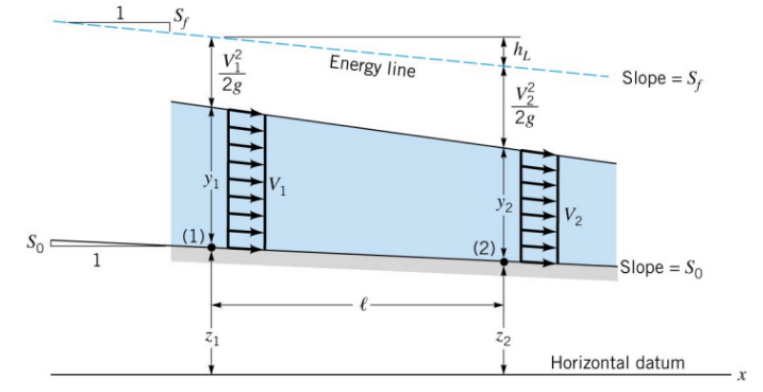

I need to get each part of this equation:
1. Hydraulic radius
2. Average Manning Friction / Velocity
3. Actal head loss

At which point I can compare the modeled versus predicted head loss. 

## Hydraulic Radius

The hydraulic length is the cross-sectional area divided by perimeter, so I will start by computing each of those

$$
R_H = \frac{A}{P} = \frac{\int h(x) dx}{\int \sqrt{1+\left(h_b'(x)\right)^2} dx}
$$

Where $h_b$ is the bed elevation and $h$ the depth, and $x$ extends across-channel. 

In [222]:
# Prep lists for area, perimeter, and channel width. 
A, P, b = [], [], []

# Need x grid size, and midpoints for derivative... 
dx = x[1]-x[0]
xm = x[1:] + dx/2

# For each position along channel... 
for yi in range(len(y)):
    
    # Compute area, which is simpler because non-wetted areas don't contribute to the integrand
    A.append(np.nansum(h_avg[yi])*dx)

    # Compute perimeter... 
    # Start with bed elevation derivative
    hb_prime = np.diff(zb[yi])/dx

    # Compute if wetted
    wetted = ~np.isnan(h_avg[yi])
    
    # For wetted x, interpolate hb_prime
    hb_prime = np.interp(x[wetted], xm, hb_prime)

    # Compute the perimeter
    P.append(np.sum(np.sqrt(1 + hb_prime))*dx)

    # Also get the width
    b.append(x[wetted][-1] - x[wetted][0])

# Compute hydraulic radius
A = np.array(A)
P = np.array(P)
b = np.array(b)
RH = A/P

Plot to see if its reasonable...

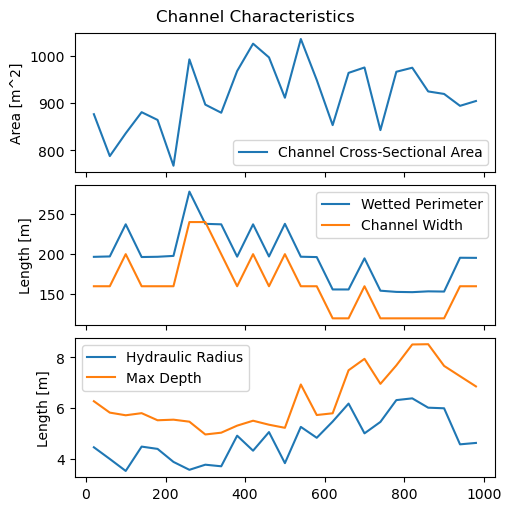

In [223]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, constrained_layout=True, figsize=(5,5))

fig.suptitle("Channel Characteristics")

axs[0].plot(y, A, label='Channel Cross-Sectional Area')
axs[0].set_ylabel("Area [m^2]")
axs[0].legend()

axs[1].plot(y, P, label='Wetted Perimeter')
axs[1].plot(y, b, label='Channel Width')
axs[1].set_ylabel("Length [m]")
axs[1].legend()

axs[2].plot(y, RH, label='Hydraulic Radius')
axs[2].plot(y, np.nanmax(h_avg, axis=1), label='Max Depth')
axs[2].set_ylabel("Length [m]")
axs[2].legend()

plt.show()

Looks reasonable. 

## Channel-Average Manning Friction

The next thing to make is a channel-averaged Manning friction, but how should I one-dimensionalize it? 

In [224]:
# Version 1: average across the channel
n_copy = np.copy(n)
n_copy[~np.isnan(h_avg)] = np.nan   # Don't use non-wetted areas for this
n_avg1 = np.nanmean(n, axis=1)   # Just get the straight-up average

# Version 2: weigh average on channel velocity. Seems fair for friction. 
n_avg2 = np.average(n, weights=v_avg, axis=1)

# Get max and min for comparison...
n_max = np.nanmax(n_copy, axis=1)
n_min = np.nanmin(n_copy, axis=1)

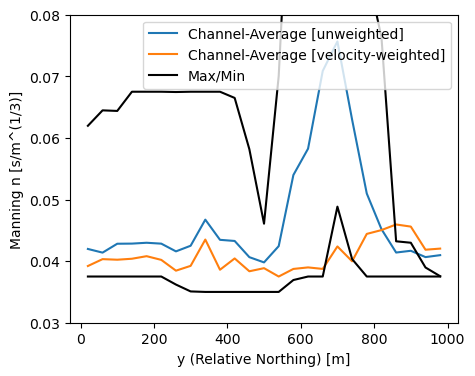

In [225]:
plt.figure(figsize=(5,4))
plt.plot(y, n_avg1, label="Channel-Average [unweighted]")
plt.plot(y, n_avg2, label="Channel-Average [velocity-weighted]")
plt.plot(y, n_max,  label="Max/Min", color='black')
plt.plot(y, n_min,  color='black')
plt.legend()
plt.ylabel("Manning n [s/m^(1/3)]")
plt.xlabel("y (Relative Northing) [m]")
plt.ylim(0.03, 0.08)
plt.show()

Makes sense to use the velocity-weighted average I think, or just assume $n=0.04$, which is consistent with a natural channel.

## Channel-Average Velocity

For the velocity, I'll start by computing the discharge, then dividing by area for an average velocity. 

In [226]:
Qy = np.nansum( v_avg * h_avg, axis=1) * dx # note v_avg here is *time* averaged, and now I'm channel-averageing it
va = Qy / A # Divide discharge by area to get velocity. 

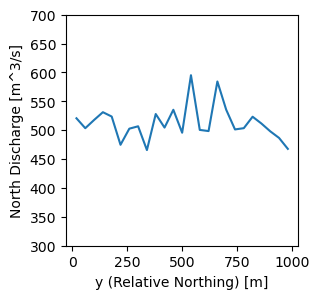

In [227]:
plt.figure(figsize=(3,3))
plt.plot(y, Qy)
plt.ylim(300, 700)
plt.xlabel("y (Relative Northing) [m]")
plt.ylabel("North Discharge [m^3/s]")
plt.show()

I invoke small variations in river direction to explain variations in north discharge. Its ok. 

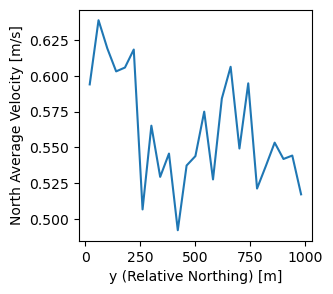

In [228]:
plt.figure(figsize=(3,3))
plt.plot(y, va)
plt.xlabel("y (Relative Northing) [m]")
plt.ylabel("North Average Velocity [m/s]")
plt.show()

Is this reasonable? It seems so, given the model output from earlier. 

## Head / Surface Elevation

In [229]:
# Just channel-average the surface elevation
za = np.nanmedian(zs_avg, axis=1)

## All together, plotted...

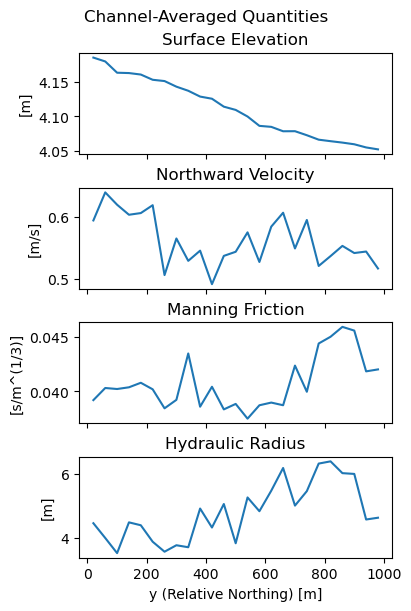

In [230]:
fig, axs = plt.subplots(nrows=4, sharex=True, constrained_layout=True, figsize=(4,6))

axs[0].plot(y, za)
axs[0].set_title("Surface Elevation")
axs[0].set_ylabel("[m]")

axs[1].plot(y, va)
axs[1].set_title("Northward Velocity")
axs[1].set_ylabel("[m/s]")

axs[2].plot(y, n_avg2)
axs[2].set_title("Manning Friction")
axs[2].set_ylabel("[s/m^(1/3)]")

axs[3].plot(y, RH)
axs[3].set_title("Hydraulic Radius")
axs[3].set_ylabel("[m]")
axs[3].set_xlabel("y (Relative Northing) [m]")

plt.suptitle("Channel-Averaged Quantities")
plt.show()

## Using Manning's Equation

Recall Manning's equation

$$
S_f = \left( \frac{v_{avg} \times n}{R_H^{2/3}} \right)^2
$$

The friction slope is then:

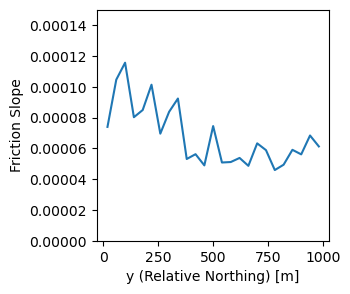

In [231]:
Sf0 = (va * n_avg2 / (RH**(2/3))) ** 2

plt.figure(figsize=(3,3))
plt.plot(y, Sf0)
plt.ylabel("Friction Slope")
plt.xlabel("y (Relative Northing) [m]")
plt.ylim(0, 0.00015)
plt.show()

To get the head loss, I want the energy head, which involves both surface elevation and average velocity. 

In [232]:
g = 9.81
e = za + va**2 / (2*g)

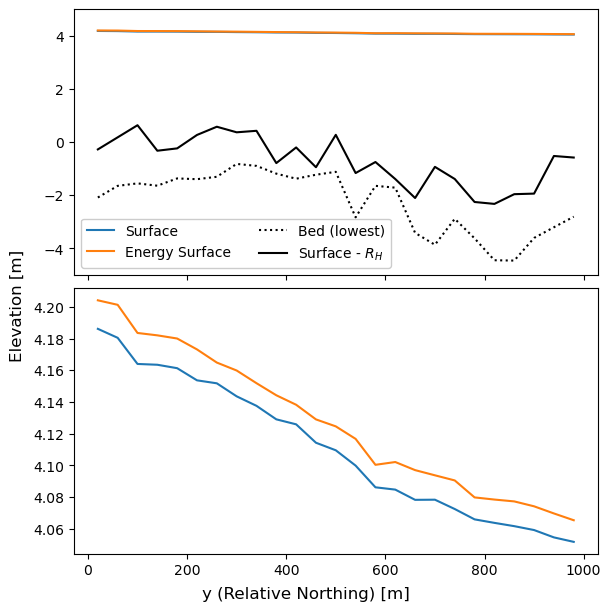

In [233]:
fig, axs = plt.subplots(nrows=2, sharex=True, constrained_layout=True, figsize=(6,6))
axs[0].plot(y, za, label='Surface') 
axs[0].plot(y, e, label='Energy Surface')
axs[0].plot(y, np.nanmin(zb, axis=1), color='black', linestyle=':', label='Bed (lowest)')
axs[0].plot(y, za-RH, label=r'Surface - $R_H$', color='black')
axs[0].legend(ncols=2, framealpha=1)
axs[0].set_ylim(-5, 5)
axs[1].plot(y, za, label='Surface') 
axs[1].plot(y, e, label='Energy Surface')
fig.supxlabel("y (Relative Northing) [m]")
fig.supylabel("Elevation [m]")
plt.show()

Compare to the figure:

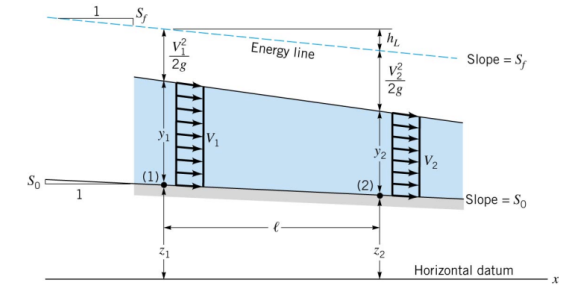

The flow is not very energetic!

In [234]:
dy = y[1] - y[0]
hl_est = -1*np.cumsum(Sf0*dy)

# Compute the theoretical head based on the same starting point
zm = hl_est + e[0] - hl_est[0]

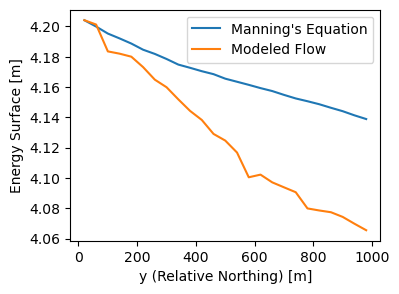

In [235]:
plt.figure(figsize=(4,3))
plt.plot(y, zm, label="Manning's Equation")
plt.plot(y, e, label='Modeled Flow')
plt.xlabel("y (Relative Northing) [m]")
plt.ylabel("Energy Surface [m]")
plt.legend()
plt.show()

So Manning's equation has kind of been validated, though the modeled flow loses slightly more energy than predicted, possibly due to turns in the river and friction in the x (east/west) dimension. 

## Momentum

So now that energy has been validated, let's try the momentum balance. The forces acting on the river segment are as follows:

1. Gravity (which depends on slope)
2. Hydrostatic forces on upstream/downstream boundaries
3. Friction force (Manning friction)

Any net force should result in an increase or decrease in momentum flux over the river segment. 

## Gravity & Pressure Forces

Gravity will be the area integral of mass times accelleration (in the y direction, determined by the slope)
$$
F_{g,y} = \rho g \iint  h(x,y) S_y(x,y) dx dy
$$

Pressure will be the sum of lower and upper pressure line integrals from the boundaries
$$
F_{p} = \frac{1}{2} \rho g \int h^2 \left( x,y_{\textrm{lower}} \right) dx - \frac{1}{2} \rho g \int h^2 \left( x,y_{\textrm{upper}} \right) dx 
$$

In [236]:
rho = 1025

# Starting with GRAVITY, in the y direction
Sy = np.diff(zb, axis=0) / dy

# Also sample the depth at the midpoints from differencing... 
# define midpoints
yc = y[1:] - dy/2

# Have to use a version of h_avg which has 0s instead of nans, for interpolation. 
hau = np.copy(h_avg)
hau[np.isnan(hau)] = 0
ht = np.array([np.interp(yc, y, hau[:,xi]) for xi in range(len(x))]).T

# Mass times accelleration times Sy
Fg = g * (rho *(ht * dx * dy)) * Sy
# Integrate over the whole domain
Fg_tot = np.nansum(Fg)

# Hydrostatic forces everywhere are just the pressure times area:
Fp = 0.5 * rho * g * (h_avg**2) * dx
# But this has to be integrated along the upstream/downstream boundaries
Fp_tot = np.nansum(Fp[0]) - np.nansum(Fp[-1])

Plot something to show how gravitational forces are shaping up:

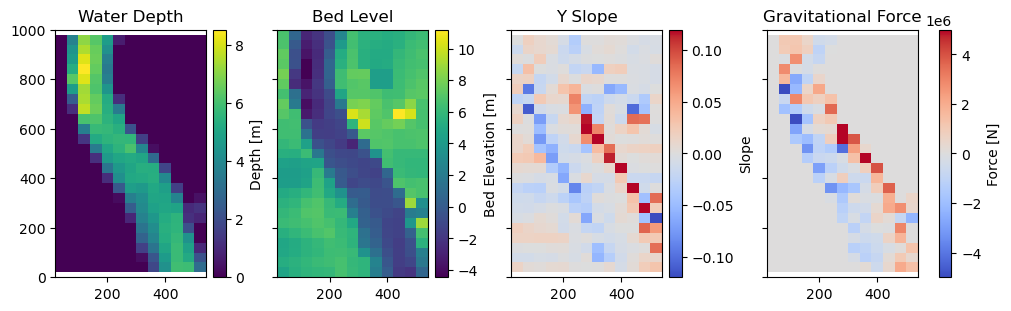

In [237]:
fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True, constrained_layout=True, figsize=(10,3))

axs[0].set_title("Water Depth")
m = axs[0].pcolormesh(x,yc,ht, shading='nearest')
plt.colorbar(m, ax=axs[0]).ax.set_ylabel("Depth [m]")

axs[1].set_title("Bed Level")
m = axs[1].pcolormesh(x,y,zb, shading='nearest')
plt.colorbar(m, ax=axs[1]).ax.set_ylabel("Bed Elevation [m]")

axs[2].set_title("Y Slope")
m = axs[2].pcolormesh(x,yc,Sy, shading='nearest', cmap='coolwarm', vmin=-0.12, vmax=0.12)
plt.colorbar(m, ax=axs[2]).ax.set_ylabel("Slope")

axs[3].set_title("Gravitational Force")
m = axs[3].pcolormesh(x,yc,Fg, shading='nearest', cmap='coolwarm', vmin=-5e6, vmax=5e6)
plt.colorbar(m, ax=axs[3]).ax.set_ylabel("Force [N]")

plt.show()

## Friction Force

In an event where friction and gravity are balanced in some wide, arbitrary uniform flow, they satisfy

$$
S_0 \rho g h = \tau 
$$

So if I sub-in the friction slope from Manning's equation, I can assert:

$$
\tau = \rho g h S_f
$$

I need an expression for $S_f$ that isn't dependent on $R_H$ though, because I'm not computing channel-averaged quantities. Without justification I will pretend $R_H \approx h$ (people, such as Bates et al 2010, say this is reasonable for wide flows) to say

$$
S_f =  v^2n^2 h^{-4/3} 
$$

$$
\tau = \rho g v^2 n^2 h^{-1/3}
$$

The friction force is then the integration of stress along the channel area:

$$
F_f = \rho g \iint v^2 n^2 h^{-1/3} dx dy 
$$

In [238]:
Sf1 = v_avg**2 * n**2 * h_avg**(-4/3)

rho = 1025
g = 9.81

Ff = -1 * rho * g * v_avg**2 * n**2 * h_avg**(-1/3) * dx * dy
Ff_tot = np.nansum(Ff)

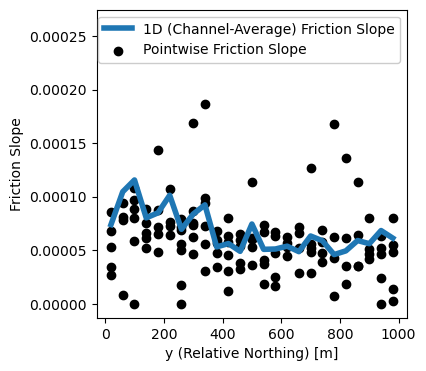

In [239]:
plt.figure(figsize=(4,4))
plt.plot(y, Sf0, label='1D (Channel-Average) Friction Slope', linewidth=4)
[plt.scatter(y, Sf1[:,xi], color='black') for xi in range(len(x))]
plt.scatter(np.nan, np.nan, color='black', label='Pointwise Friction Slope')
plt.legend(framealpha=1)
plt.xlabel("y (Relative Northing) [m]")
plt.ylabel("Friction Slope")
plt.show()

## Momentum Flux Changes
Now I just need the momentum flux at the boundaries. Units check: $F=ma$, and $N=kg\cdot m / s^2$. Momentum is $M=mv$ and $kg\cdot m / s$. The momentum flux is the flow of momentum per second, which is the same units as force. Writing momentum flux in terms of velocity and discharge:
$$
MF = ( \rho Q ) v
$$
In other words, the mass flow ($\rho Q$) times the velocity to convert it into a momentum flow. 

In [240]:
# Discharge (per cell)
Qy = v_avg * h_avg
# Momentum flux (per cell)
MF = rho * Qy * v_avg
# Total change over the river segment
dMF_tot = np.nansum(MF[-1]) - np.nansum(MF[0]) 

## Comparison

In [241]:
print("GRAVITY            + HYDROSTATIC PRESSURE + FRICTION              = CHANGE IN MOMENTUM FLUX")
print(Fg_tot/1e7, '+', Fp_tot/1e7, '    +', Ff_tot/1e7, '=', dMF_tot/1e7)
print("                                                      RESIDUAL    =", Fg_tot/1e7 + Fp_tot/1e7 + Ff_tot/1e7 - dMF_tot/1e7)

GRAVITY            + HYDROSTATIC PRESSURE + FRICTION              = CHANGE IN MOMENTUM FLUX
0.27644300132053756 + -0.2597806796875     + -0.05468436355531216 = -0.00019612681
                                                      RESIDUAL    = -0.03782591510873996


It sort of looks ok

## Time Domain

I'm going to plot the same balance of forces but now for each time step.

In [242]:
u = sf.results['u'].values
v = sf.results['v'].values
z_surface = sf.results['zs'].values
z_bottom  = sf.results['zb'].values
h = z_surface - z_bottom

v = v[:,yok2][:,:,xok2]
u = u[:,yok2][:,:,xok2]
h = h[:,yok2][:,:,xok2]

In [243]:
# Gravity
# Get the grid-center evaluated depths for each time
hu = np.copy(h)
hu[np.isnan(hu)] = 0
ht = np.array([np.array([np.interp(yc, y, hu[ti,:,xi]) for xi in range(len(x))]).T for ti in range(len(t))])
# Mass times accelleration times Sy
Sy = np.diff(zb, axis=0) / dy
Fg = g * (rho *(ht * dx * dy)) * Sy
# Integrate over the whole domain (x,y axes)
Fg_tot = np.nansum(np.nansum(Fg, axis=2),axis=1)

# Hydrostatic forces everywhere are just the pressure times area:
Fp = 0.5 * rho * g * (h**2) * dx
# But this has to be integrated along the upstream/downstream boundaries
Fp_tot = np.nansum(Fp[:,0],axis=1) - np.nansum(Fp[:,-1],axis=1)

# Friction
Ff = -1 * rho * g * v**2 * n**2 * h**(-1/3) * dx * dy
Ff_tot = np.nansum(np.nansum(Ff, axis=2), axis=1)

# Discharge (per cell)
Qy = v * h * dx
# Momentum flux (per cell)
MF = rho * Qy * v
# Total change over the river segment
dMF_tot = np.nansum(MF[:,0], axis=1) - np.nansum(MF[:,-1], axis=1)

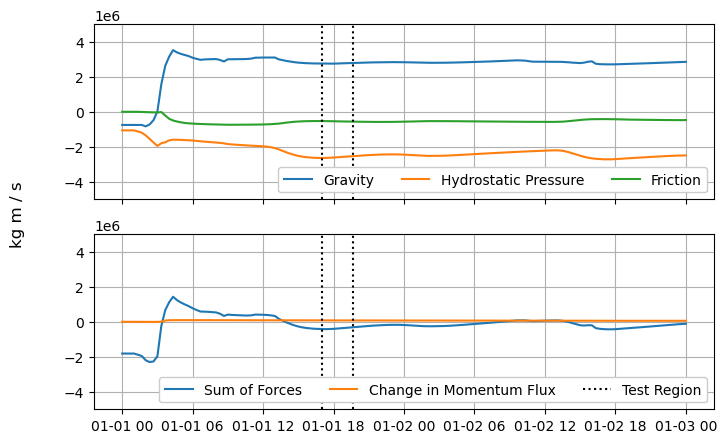

In [244]:
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,5))

# Plot each term
axs[0].plot(t, Fg_tot, label='Gravity')
axs[0].plot(t, Fp_tot, label='Hydrostatic Pressure')
axs[0].plot(t, Ff_tot, label='Friction')

# Plot observed change in flux and residual
axs[1].plot(t, Fg_tot + Fp_tot + Ff_tot, label='Sum of Forces')
axs[1].plot(t, dMF_tot, label='Change in Momentum Flux')

# Show where I averaged for the test... 
axs[0].axvline(t[tok][0], color='black', linestyle=':')
axs[0].axvline(t[tok][-1], color='black', linestyle=':')
axs[1].axvline(t[tok][0], color='black', linestyle=':')
axs[1].axvline(t[tok][-1], color='black', linestyle=':', label='Test Region')

# Legends, labels, limits
axs[0].grid()
axs[1].grid()
axs[0].legend(loc=4, ncols=3, framealpha=1)
axs[1].legend(loc=4, ncols=3, framealpha=1)
axs[1].set_ylim(-5e6, 5e6)
fig.supylabel(r"kg m / s")

plt.show()

Did I do this right? Hard to say... Seems like the momentum flux changes not very much compared to the momentum terms. Zooming in:

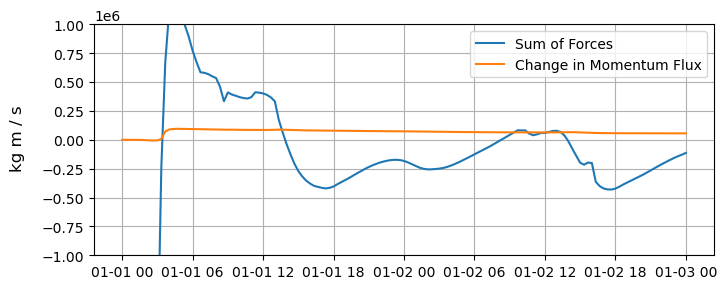

In [245]:
fig = plt.figure(figsize=(8,3))
plt.plot(t, Fg_tot + Fp_tot + Ff_tot, label='Sum of Forces')
plt.plot(t, dMF_tot, label='Change in Momentum Flux')
plt.legend()
plt.grid()
fig.supylabel(r"kg m / s")
plt.ylim(-1e6, 1e6)
plt.show()

Its like the discharge and velocity are barely changing at all at the boundaries, but the water level and gravity/hydrostatic forces are changing a lot. 

I'm going to tentatively conclude the math might be right, but if so this is a test case sensitive to small errors.